In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import numpy

# *** A. Camera calibration// training with camera_cal image***

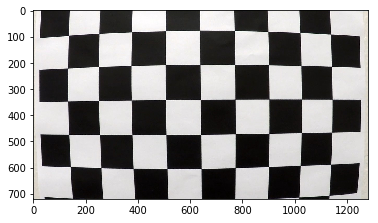

In [2]:
images = glob.glob('camera_cal/*.jpg')
objpoints = []
imgpoints = []
nx = 9
ny = 6
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        imgpoints.append(corners) 
        objpoints.append(objp) 
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
plt.imshow(img)

# ***Camera calibration// test with camera_cal-1 image and  the test_images/test1.jpg***

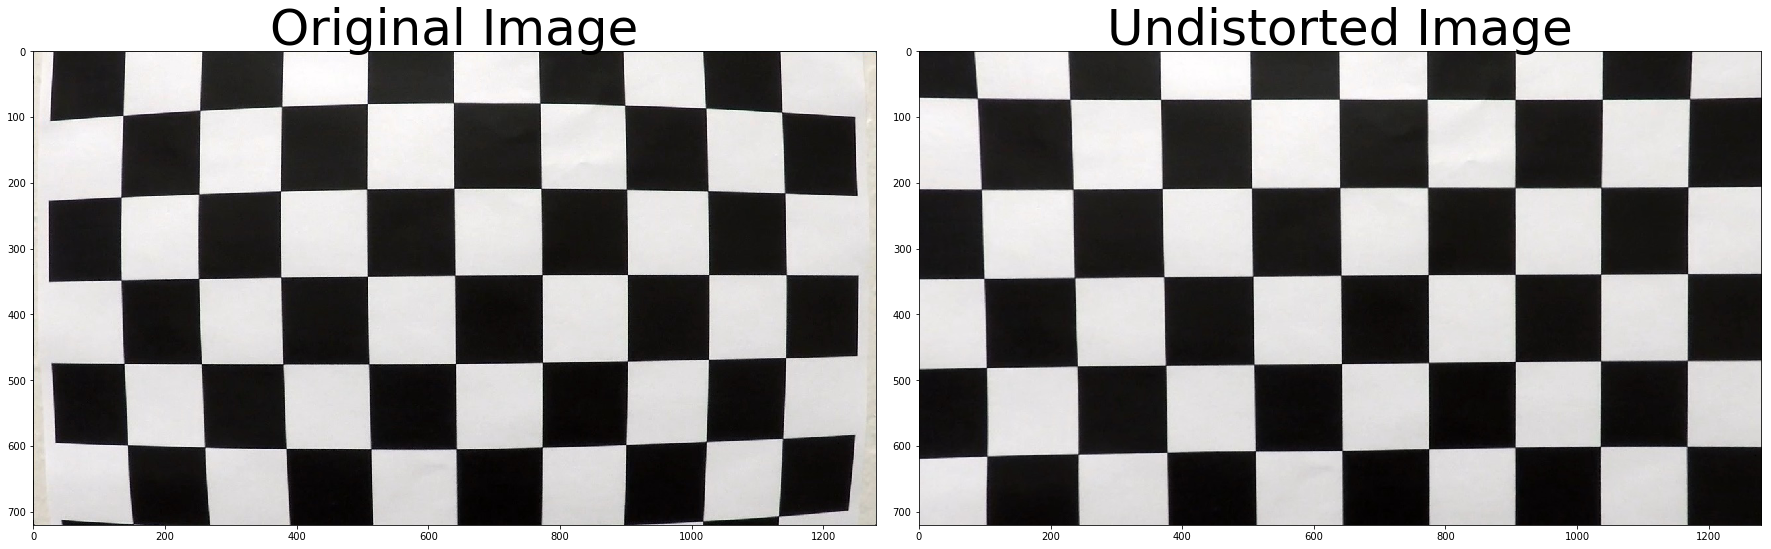

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
img = mpimg.imread('camera_cal/calibration1.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)#call the funtion in the future
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

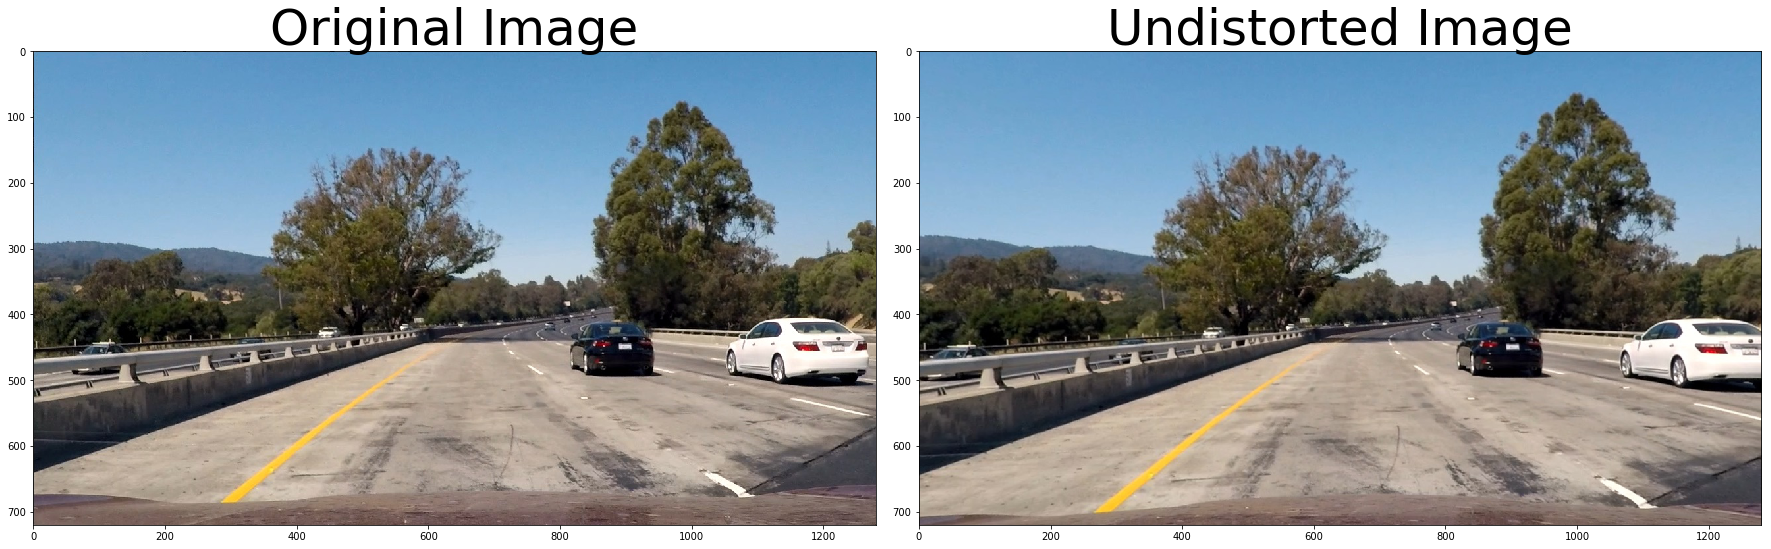

In [4]:
img = mpimg.imread('test_images/test1.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)#call the funtion in the future
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# B. apply combined_filter to bird view

## b1.apply a  Color and Gradient combined filter

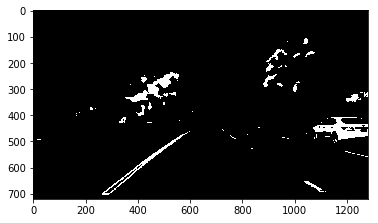

In [5]:

def combined_filter(undistorted):

    hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)
    L_channel = hls[:,:,1]
    lab = cv2.cvtColor(undistorted, cv2.COLOR_RGB2Lab)

    #The b channel from Lab with thresholds between about 150 and 200 (for yellow lines).
    b_channel = lab[:,:,2]
    thresh_min = 150
    thresh_max = 200
    B_binary = np.zeros_like(b_channel)
    B_binary[(b_channel >= thresh_min) & (b_channel <= thresh_max)] = 1

    
    #The L channel from LUV with thresholds between about 225 and 255 (for white lines).

    # Threshold color channel
    L_thresh_min = 225
    L_thresh_max = 255
    L_binary = np.zeros_like(L_channel)
    L_binary[(L_channel >= L_thresh_min) & (L_channel <= L_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(B_binary), B_binary, L_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(L_binary)
    combined_binary[(B_binary == 1) | (L_binary == 1)] = 1
    return combined_binary





combined_binary = combined_filter(undistorted)



plt.imshow(combined_binary, cmap='gray')


## b2. warper with perspect tranform to get the bird view

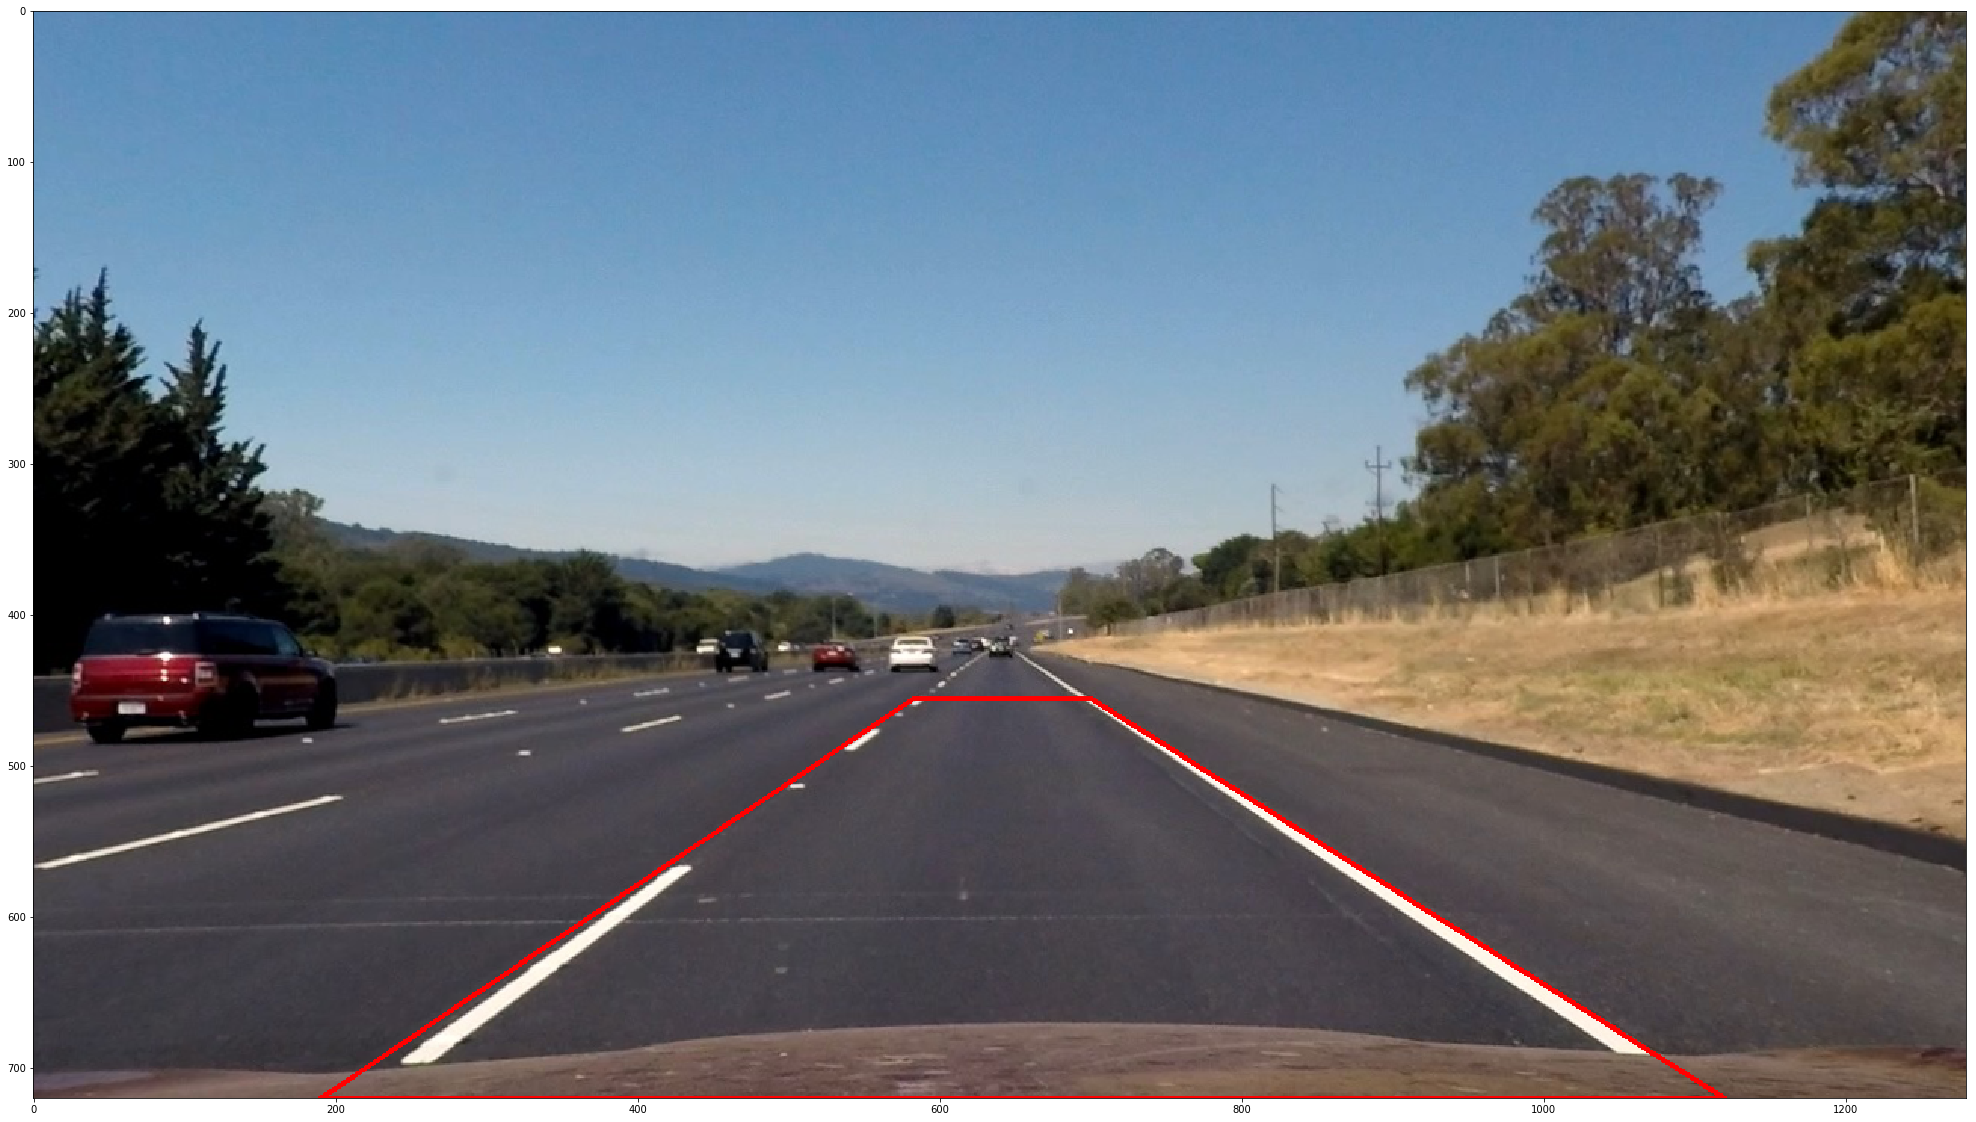

In [6]:
img = mpimg.imread('test_images/straight_lines2.jpg')


undistorted = cal_undistort(img, objpoints, imgpoints)#call the funtion in the future
# define the line straight forward as the zone we want in undistorted
left_top = (190, 720)
left_bottom =  (583, 455)
right_top = (1120, 720)
right_bottom = (700, 455)

left_top_x,left_top_y = left_top
left_bottom_x,left_bottom_y = left_bottom
right_top_x,right_top_y = right_top
right_bottom_x,right_bottom_y = right_bottom

copy = undistorted.copy()
color = 255
w = 2
cv2.line(copy, left_top, left_bottom, color, w)
cv2.line(copy, left_bottom, right_bottom, color, w)
cv2.line(copy, right_bottom, right_top, color, w)
cv2.line(copy, right_top, left_top, color, w)
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(copy)

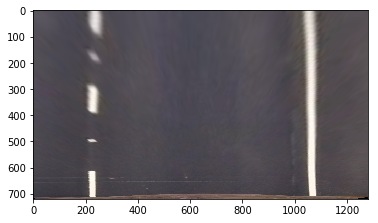

In [7]:

def perspective_wrapper(undistorted):
    left_top = (190, 720)
    left_bottom =  (583, 455)
    right_top = (1120, 720)
    right_bottom = (700, 455)
    left_top_x,left_top_y = left_top
    left_bottom_x,left_bottom_y = left_bottom
    right_top_x,right_top_y = right_top
    right_bottom_x,right_bottom_y = right_bottom
    src = np.float32([ 
    [left_bottom_x, left_bottom_y],
    [right_bottom_x, right_bottom_y],
    [right_top_x, right_top_y],
    [left_top_x, left_top_y]

    ])
    offset = 200
    img_size = (undistorted.shape[1], undistorted.shape[0])
    dst = np.float32([
        [offset, 0],
        [img_size[0]-offset, 0],
        [img_size[0]-offset, img_size[1]], 
        [offset, img_size[1]]
    ])
    M = cv2.getPerspectiveTransform(src, dst)
    invM =  cv2.getPerspectiveTransform( dst,src)
    warped = cv2.warpPerspective(undistorted, M, img_size)
    return warped,invM

warped,invM = perspective_wrapper(undistorted)
plt.imshow(warped)


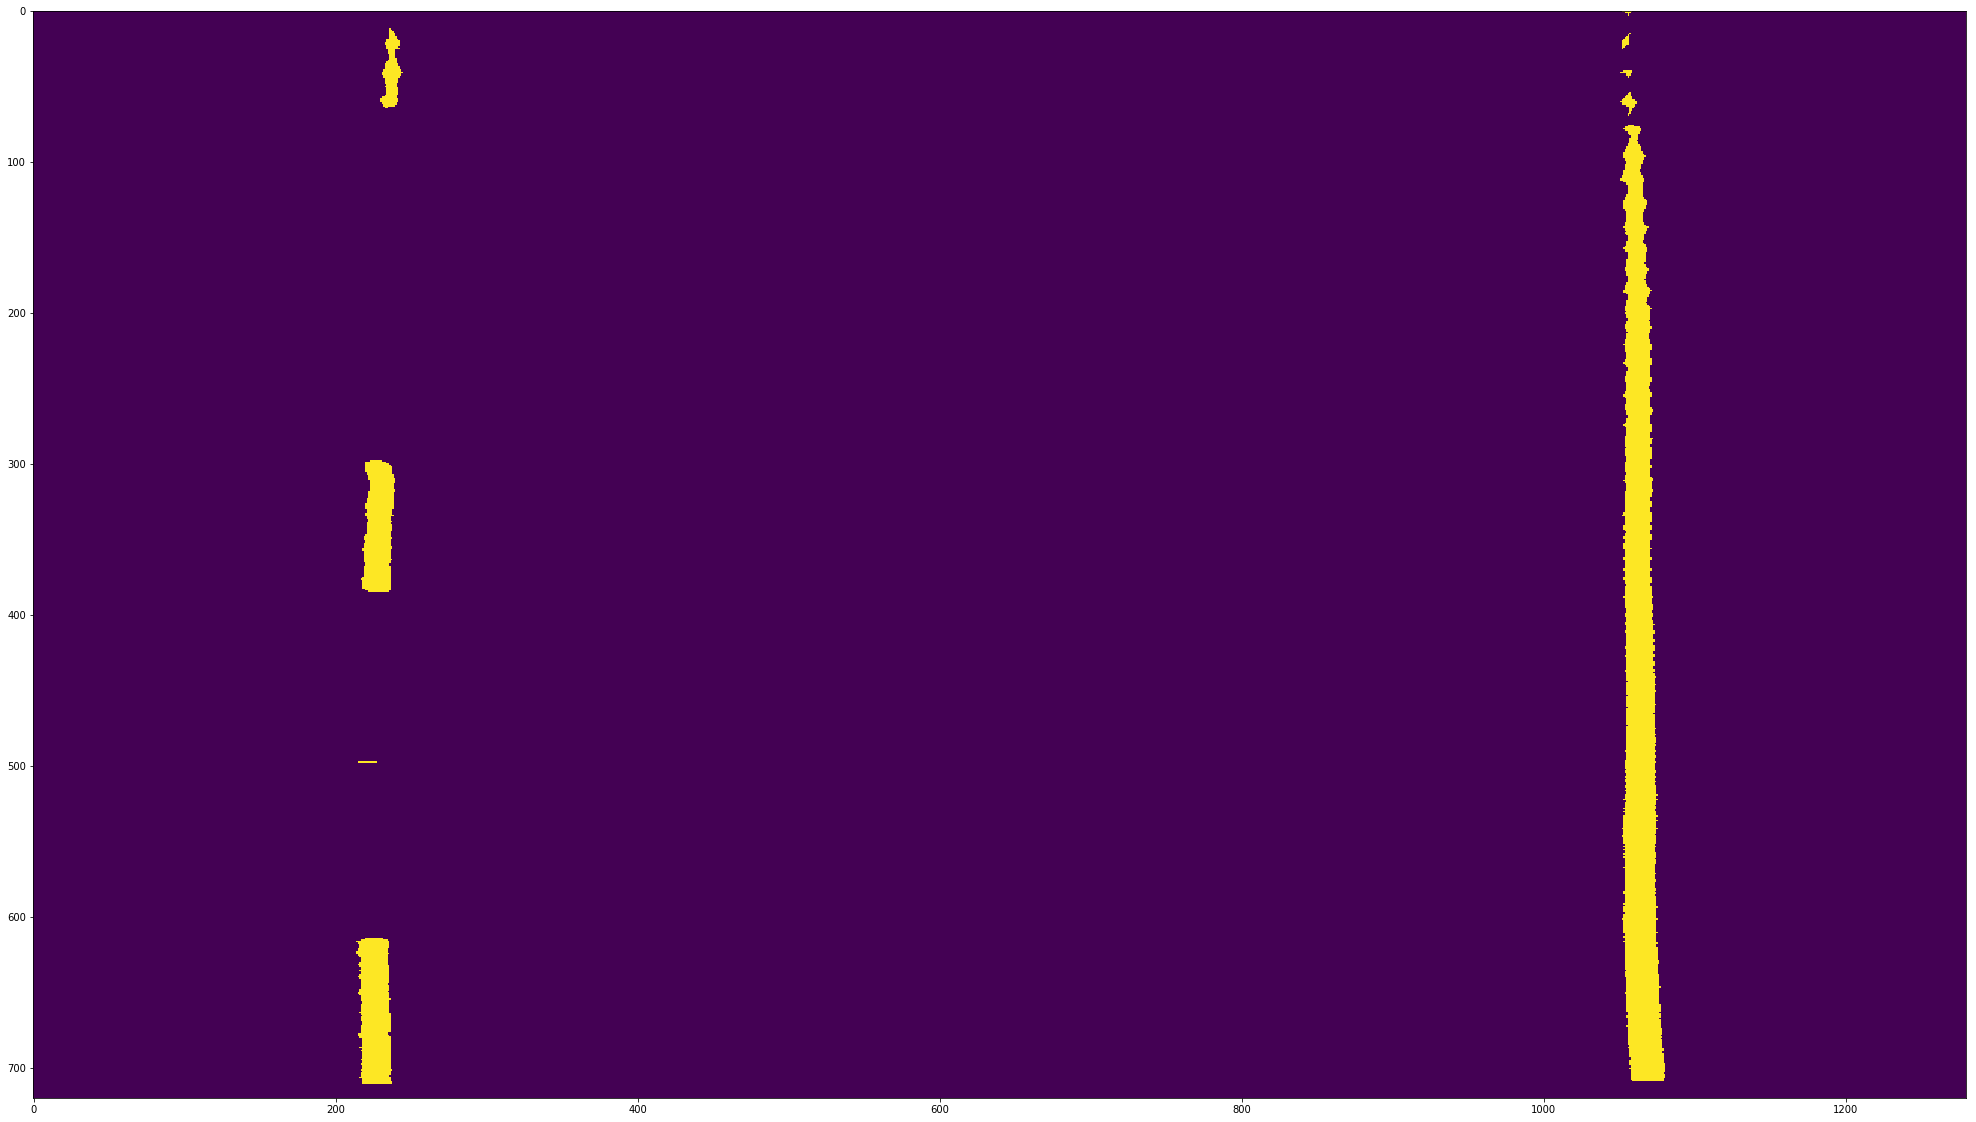

In [8]:
warped_binary = combined_filter(warped)
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(warped_binary)

#  C.trace the line

 ## c1. using the Histogram Peaks can recogizate the left lane and the right lane 

In [9]:
def find_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    margin = 100
    minpix = 50
    window_height = np.int(binary_warped.shape[0]//nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    return leftx, lefty, rightx, righty, out_img


## c2. compute the curverad and the diff_from_center

In [10]:

def measure_curvature_pixels(img, left_fit_m, right_fit_m):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_m[0]*y_eval*ym_per_pix + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
    right_curverad = ((1 + (2*right_fit_m[0]*y_eval*ym_per_pix + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])
    return left_curverad, right_curverad

def fit_polynomial(binary_warped):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    return out_img,left_fitx,right_fitx,left_fit_m,right_fit_m,left_fit,right_fit


def drawLine(img, left_fit, right_fit,invM):
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, invM, (img.shape[1], img.shape[0])) 
    plt.imshow(newwarp)
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

def dist_center(image,left_fitx,right_fitx):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    lane_center = (left_fitx[-1] + right_fitx[-1]) / 2
    image_center = image.shape[1] / 2
    offset = (lane_center - image_center) * xm_per_pix
    #diff_from_center = (xMax -rightx[-1]-leftx[-1] )*xm_per_pix/2
    #print(xMax/2 ,rightx[-1],leftx[-1])
    return offset

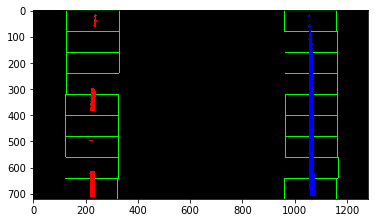

In [11]:
out_img,left_fitx,right_fitx,left_fit_m,right_fit_m,left_fit,right_fit = fit_polynomial(warped_binary)
plt.imshow(out_img)

4503.47502398 867193.835918
0.033758001905


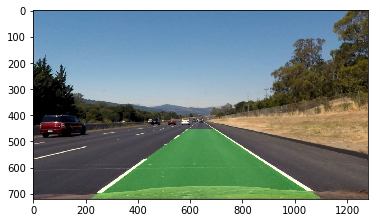

In [12]:

output  = drawLine(undistorted, left_fit, right_fit,invM)

left_curverad, right_curverad = measure_curvature_pixels(warped_binary, left_fit_m, right_fit_m)

print (left_curverad, right_curverad)
diff_from_center = dist_center(img,left_fitx,right_fitx)

print (diff_from_center)

plt.imshow(output)

# D.use a pipline to include all process

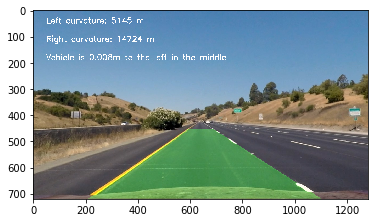

In [13]:
def pipeline(img):
    undistorted = cal_undistort(img, objpoints, imgpoints)#call the funtion in the future
    warped,invM = perspective_wrapper(undistorted)
    warped_binary = combined_filter(warped)
    out_img,left_fitx,right_fitx,left_fit_m,right_fit_m,left_fit,right_fit = fit_polynomial(warped_binary)
    left_curverad, right_curverad = measure_curvature_pixels(warped_binary, left_fit_m, right_fit_m)
    diff_from_center = dist_center(img,left_fitx,right_fitx)
    output  = drawLine(undistorted, left_fit, right_fit,invM)
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    fontScale = 1
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 120), font, fontScale, fontColor, 2)
    if (diff_from_center<0):
        cv2.putText(output, 'Vehicle is {:3f}m to the right in the middle'.format(-diff_from_center), (50, 190), font, fontScale, fontColor, 2)
    else :
        cv2.putText(output, 'Vehicle is {:.3f}m to the left in the middle'.format(diff_from_center), (50, 190), font, fontScale, fontColor, 2)

    return output

#img = mpimg.imread('test_images/straight_lines2.jpg')
img = mpimg.imread('test_images/straight_lines1.jpg')

plt.imshow(pipeline(img))

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.02310144/28549024 bytes (8.1%5545984/28549024 bytes (19.49019392/28549024 bytes (31.612410880/28549024 bytes (43.5%15908864/28549024 bytes (55.7%19406848/28549024 bytes (68.0%22839296/28549024 bytes (80.0%26288128/28549024 bytes (92.1%28549024/28549024 bytes (100.0%)
  Done
File saved as /root/.imageio/ffmpeg/ffmpeg.linux64.


# process the pipline on project_video_out.mp4

In [ ]:
project_video_out = 'project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip = VideoFileClip('project_video.mp4')
yellow_clip = clip.fl_image(pipeline)
%time yellow_clip.write_videofile(project_video_out, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [04:59<00:00,  4.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 2min 40s, sys: 4.24 s, total: 2min 44s
Wall time: 5min 2s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_out))